In [1]:

from openai import OpenAI
import json
from dotenv import load_dotenv, find_dotenv

_ : bool = load_dotenv(find_dotenv()) # read local .env file

client : OpenAI = OpenAI()


# The basic sequence of steps for function calling is as follows:
* Call the model with the user query and a set of functions defined in the functions parameter.
* The model can choose to call one or more functions; if so, the content will be a stringified JSON object
* adhering to your custom schema (note: the model may hallucinate parameters).
*  Parse the string into JSON in your code, and call your function with the provided arguments if they exist.
*  Call the model again by appending the function response as a new message, and let the model summarize the 
*  results back to the user.

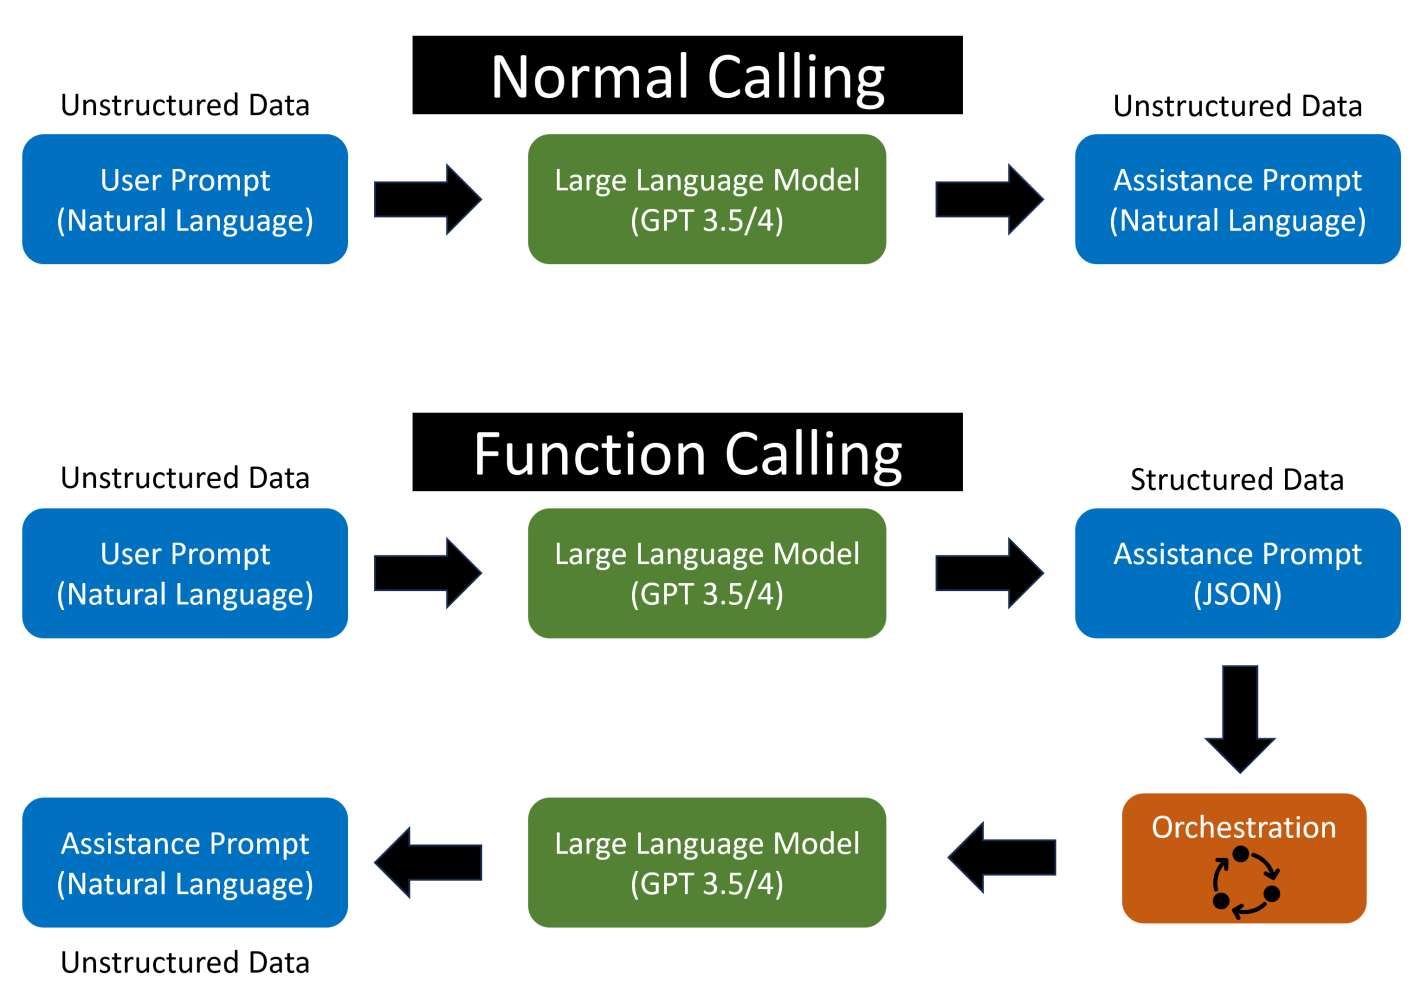
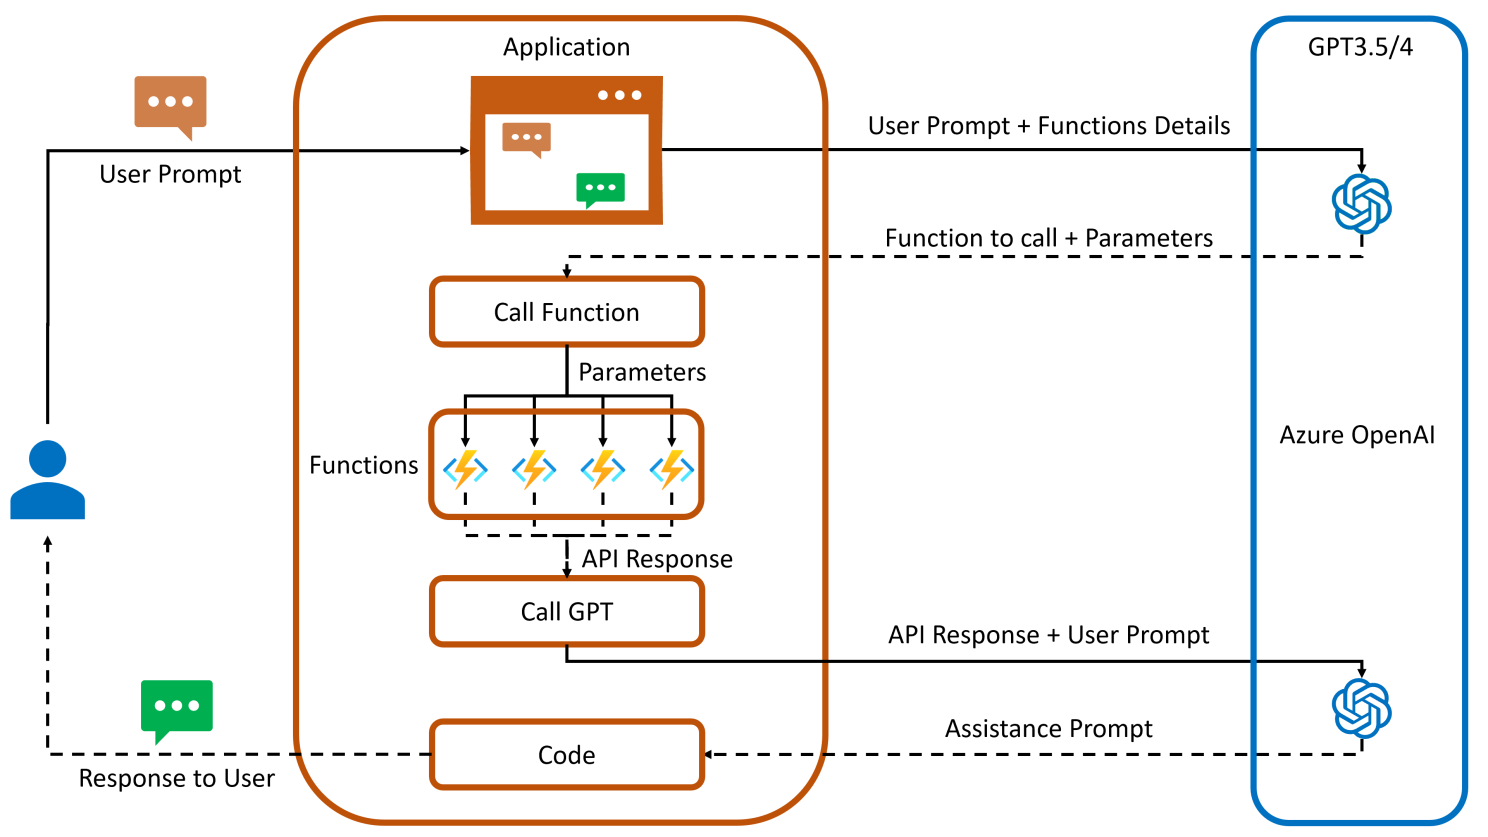

In [21]:
# Example dummy function hard coded to return the same weather
# In production, this could be your backend API or an external API
def get_current_weather(location:str, unit:str="fahrenheit")->str:
    """Get the current weather in a given location"""
    if "tokyo" in location.lower():
        return json.dumps({"location": "Tokyo", "temperature": "10", "unit": "celsius"})
    elif "san francisco" in location.lower():
        return json.dumps({"location": "San Francisco", "temperature": "72", "unit": "fahrenheit"})
    elif "paris" in location.lower():
        return json.dumps({"location": "Paris", "temperature": "22", "unit": "celsius"})
    else:
        return json.dumps({"location": location, "temperature": "unknown"})

In [22]:
from openai.types.chat.chat_completion import ChatCompletionMessage, ChatCompletion
# from openai.types.chat.chat_completion import ChatCompletionMessageParam, ChatCompletionMessageParam

def run_conversation(main_request: str)->str:
    # Step 1: send the conversation and available functions to the model
    messages = [{"role": "user", "content": main_request}]
    tools = [
        {
            "type": "function",
            "function": {
                "name": "get_current_weather",
                "description": "Get the current weather in a given location",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "location": {
                            "type": "string",
                            "description": "The city and state, e.g. San Francisco, CA",
                        },
                        "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
                    },
                    "required": ["location"],
                },
            },
        }
    ]

    # First Request
    response: ChatCompletion = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=messages,
        tools=tools,
        tool_choice="auto",  # auto is default, but we'll be explicit
    )
    response_message: ChatCompletionMessage = response.choices[0].message
    display("* First Response: ", dict(response_message))

    tool_calls = response_message.tool_calls
    display("* First Reponse Tool Calls: ", list(tool_calls))

    # Step 2: check if the model wanted to call a function
    if tool_calls:
        # Step 3: call the function
        # Note: the JSON response may not always be valid; be sure to handle errors
        available_functions = {
            "get_current_weather": get_current_weather,
        }  # only one function in this example, but you can have multiple
        
        messages.append(response_message)  # extend conversation with assistant's reply
        
        # Step 4: send the info for each function call and function response to the model
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_to_call = available_functions[function_name]
            function_args = json.loads(tool_call.function.arguments)
            function_response = function_to_call(
                location=function_args.get("location"),
                unit=function_args.get("unit"),
            )
            messages.append(
                {
                    "tool_call_id": tool_call.id,
                    "role": "tool",
                    "name": function_name,
                    "content": function_response,
                }
            )  # extend conversation with function response
        display("* Second Request Messages: ", list(messages))
        second_response: ChatCompletion = client.chat.completions.create(
            model="gpt-3.5-turbo-1106",
            messages=messages,
        )  # get a new response from the model where it can see the function response
        print("* Second Response: ", dict(second_response))
        return second_response.choices[0].message.content

In [23]:
run_conversation("What's the weather like in Tokyo, San Francisco,  and Paris?")

'* First Response: '

{'content': None,
 'role': 'assistant',
 'function_call': None,
 'tool_calls': [ChatCompletionMessageToolCall(id='call_u6XEjuL23NRSFR9h5aSWztNh', function=Function(arguments='{"location": "Tokyo", "unit": "celsius"}', name='get_current_weather'), type='function'),
  ChatCompletionMessageToolCall(id='call_AOZIiX6kiCLxnARzwfhbw0YE', function=Function(arguments='{"location": "San Francisco", "unit": "celsius"}', name='get_current_weather'), type='function'),
  ChatCompletionMessageToolCall(id='call_IGTZfKcmkpQW7kBOEQGSB0wa', function=Function(arguments='{"location": "Paris", "unit": "celsius"}', name='get_current_weather'), type='function')]}

'* First Reponse Tool Calls: '

[ChatCompletionMessageToolCall(id='call_u6XEjuL23NRSFR9h5aSWztNh', function=Function(arguments='{"location": "Tokyo", "unit": "celsius"}', name='get_current_weather'), type='function'),
 ChatCompletionMessageToolCall(id='call_AOZIiX6kiCLxnARzwfhbw0YE', function=Function(arguments='{"location": "San Francisco", "unit": "celsius"}', name='get_current_weather'), type='function'),
 ChatCompletionMessageToolCall(id='call_IGTZfKcmkpQW7kBOEQGSB0wa', function=Function(arguments='{"location": "Paris", "unit": "celsius"}', name='get_current_weather'), type='function')]

'* Second Request Messages: '

[{'role': 'user',
  'content': "What's the weather like in Tokyo, San Francisco,  and Paris?"},
 ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_u6XEjuL23NRSFR9h5aSWztNh', function=Function(arguments='{"location": "Tokyo", "unit": "celsius"}', name='get_current_weather'), type='function'), ChatCompletionMessageToolCall(id='call_AOZIiX6kiCLxnARzwfhbw0YE', function=Function(arguments='{"location": "San Francisco", "unit": "celsius"}', name='get_current_weather'), type='function'), ChatCompletionMessageToolCall(id='call_IGTZfKcmkpQW7kBOEQGSB0wa', function=Function(arguments='{"location": "Paris", "unit": "celsius"}', name='get_current_weather'), type='function')]),
 {'tool_call_id': 'call_u6XEjuL23NRSFR9h5aSWztNh',
  'role': 'tool',
  'name': 'get_current_weather',
  'content': '{"location": "Tokyo", "temperature": "10", "unit": "celsius"}'},
 {'tool_call_id': 'call_AOZIiX6kiCLxnARzwfhbw0YE',
  'role': 'tool',
  

* Second Response:  {'id': 'chatcmpl-8QuxjIMAbwF1dAnImaZ4nSzzgSWMI', 'choices': [Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content="The current weather in Tokyo is 10°C, in San Francisco it's 72°F, and in Paris it's 22°C.", role='assistant', function_call=None, tool_calls=None))], 'created': 1701426183, 'model': 'gpt-3.5-turbo-1106', 'object': 'chat.completion', 'system_fingerprint': 'fp_eeff13170a', 'usage': CompletionUsage(completion_tokens=28, prompt_tokens=170, total_tokens=198)}


"The current weather in Tokyo is 10°C, in San Francisco it's 72°F, and in Paris it's 22°C."